# Housing Market Trends in Iowa - Prediction with Linear Regression Models

Aim of this project is to gauge the effectivness of simple linear models in predicting the property value in Ames, Iowa based on a number of predictors. More information on the data set we will use can be found in the following [article](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627).

The project is composed of the following sections:
* Data cleaning and transformation
* Selecting meaningful features that correlate with the response variable
* Designing a train and test module to evaluate different models

### Data import and transformation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
%matplotlib inline

ames_houses = pd.read_csv("AmesHousing.tsv", sep="\t")

The first helper function we create will help us transform the predictors in our training data set. We use this function to perform data cleaning and to transform the predictors in the following manner:
* We first drop columns containing more than 10% NA values. 
* We drop columns that leak the sale and that could bias the machine learning model. 
* We fill the columns containing less then 10% NA values with the mode of the column. 
* We combine existing predictors to create new ones.
* We remove the predictors that are not useful for machine learning, and we convert all of the remaining predictors to the right data type.
* Finally we scale all the numerical predictors using the minmax scaling

In [2]:
def transform_features():
    
    # identify columns with more than 10% NaN values and drop them
    na_percentage = ames_houses.isnull().sum() / ames_houses.shape[0]
    na_columns = na_percentage[na_percentage > 0.10].index
    train = ames_houses.drop(na_columns, axis=1)
    
    # fill columns with less than 10% NaN values with the mode of the column
    low_na_columns = na_percentage[(na_percentage < 0.10) & (na_percentage !=0)].index
    na_replacement = ames_houses[low_na_columns].mode().T
    na_replacement = pd.Series([na_replacement.loc[i][0] for i in na_replacement.index], index=na_replacement.index)
    train[low_na_columns] = train[low_na_columns].fillna(na_replacement)
    
    # add new features by transforming the old ones
    train["years_until_remod"] = train["Year Remod/Add"] - train["Year Built"]
    train["qual_cond"] = (train["Overall Qual"] + train["Overall Cond"]) / 2
    
    #drop features that leak the sale
    train = train.drop(["Yr Sold", "Sale Type", "Mo Sold", "Sale Condition"], axis=1)
    
    #drop features not useful for machine learning
    train = train.drop(["Garage Yr Blt", "MS SubClass", "MS Zoning"], axis=1)
    
    # convert numerical data to categorical
    train["Bsmt Full Bath"] = train["Bsmt Full Bath"].astype("category")        
    train["Bsmt Half Bath"] = train["Bsmt Half Bath"].astype("category")
    train["Full Bath"] = train["Full Bath"].astype("category")
    train["Half Bath"] = train["Half Bath"].astype("category")
    train["Bedroom AbvGr"] = train["Bedroom AbvGr"].astype("category")
    train["Kitchen AbvGr"] = train["Kitchen AbvGr"].astype("category")
    
    # scale all numerical columns
    global numerical_cols
    numerical_cols = []
    for col in train.drop("SalePrice", axis=1).columns:
        if (train.dtypes[col] == "float64") or (train.dtypes[col] == "int64"):
            numerical_cols.append(col)

    scaler = MinMaxScaler()
    scaler.fit(train[numerical_cols])
    train[numerical_cols] = scaler.transform(train[numerical_cols])
    numerical_cols.append("SalePrice")
    
    return train

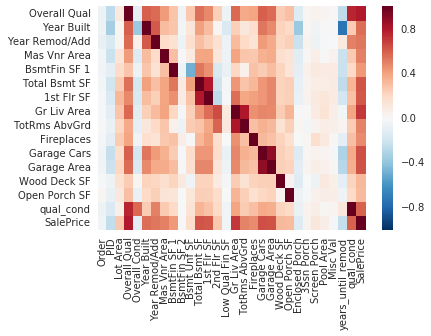

In [3]:
# transforming the data set
train = transform_features()

# selecting features that correlate strongly with sale price
mask = train[numerical_cols].corr()["SalePrice"].abs() > 0.3
strong_corr = train[numerical_cols].corr()[mask]

# correlation heatmap of the features
sns.heatmap(strong_corr)

### Feature Selection
The second function we create will allow us to select particular features that we want to use for modelling.
In order to do that we perform the following:
* We drop columns which have a correlation coefficient of less than 0.3 with the sale price
* We drop categorical columns which can take on more than 5 values
* We drop categorical columns which can take fewer values and more than 95% of the data is represented by a single value from the said column

In [4]:
def select_features(data):
    
    # drop numerical cols that are not correlated with response
    non_sig_cols = data[numerical_cols].corr()[mask == False].index
    data = data.drop(non_sig_cols, axis = 1)
    
    # drop categorical columns with too many values
    categorical_data = data.dtypes[(train.dtypes == "object") | (data.dtypes == "category")].index
    for col in categorical_data:
        data[col] = data[col].astype("category")
        data[col] = data[col].cat.codes
    category_surplus = data[categorical_data].nunique()[data[categorical_data].nunique() > 5].index
    categorical_data = data[categorical_data].nunique()[data[categorical_data].nunique() <= 5].index
    data = data.drop(category_surplus, axis=1)
    
    # drop categorical columns with low variance
    low_variance_cols = []
    for col in data[categorical_data].columns:
        value_check = data[col].value_counts()[0] / data.shape[0]
        if value_check >= 0.95:
            low_variance_cols.append(col)

    data_final = data.drop(low_variance_cols, axis=1)
    
    return data_final

In [5]:
clean_data = select_features(train)

### Model training and evaluation

The last function will help us train and evaluate models efficiently. The following block executes the following:
* Splitting the data for training and testing
* Fitting the model and making predictions on the test data
* Implementing the n-fold cross validation for more robust evaluation

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

def train_and_test(data, k=0):
    # classic training and test validation
    if k == 1:
        train = data[:1460]
        test = data[1460:]
    
        lr = LinearRegression()
        lr.fit(train.drop("SalePrice", axis=1), train["SalePrice"])
    
        test_predictions = lr.predict(test.drop("SalePrice", axis=1))
        mse = mean_squared_error(test["SalePrice"], test_predictions)
        rmse = np.sqrt(mse)
        
        return rmse
    
    # 2-fold cross validation implementation
    elif k == 2:
        data = data.sample(frac=1)
        fold_one = data[:1460]
        fold_two = data[1460:]
        
        lr = LinearRegression()
        
        lr.fit(fold_one.drop("SalePrice", axis=1), fold_one["SalePrice"])
        test_predictions = lr.predict(fold_two.drop("SalePrice", axis=1))
        mse1 = mean_squared_error(fold_two["SalePrice"], test_predictions)
        rmse1 = np.sqrt(mse1)
        
        lr.fit(fold_two.drop("SalePrice", axis=1), fold_two["SalePrice"])
        test_predictions = lr.predict(fold_one.drop("SalePrice", axis=1))
        mse2 = mean_squared_error(fold_one["SalePrice"], test_predictions)
        rmse2 = np.sqrt(mse2)
        
        return (rmse1 + rmse2) / 2
    
    # k-fold cross validation where k > 2
    elif k > 2:
        data = data.sample(frac=1)
        fold_size = round(data.shape[0] / k)
        start = 0
        end = fold_size
        rmse_all = []
        lr = LinearRegression()
        
        for i in range(1, k):
            fold = data[start:end]
            rest = pd.concat([data[:start], data[end:]])
            lr.fit(rest.drop("SalePrice", axis=1), rest["SalePrice"])
            preds = lr.predict(fold.drop("SalePrice", axis=1))
            mse = mean_squared_error(fold["SalePrice"], preds)
            rmse = np.sqrt(mse)
            rmse_all.append(rmse)
            start = start + fold_size
            end = end + fold_size
            
        start = (k-1) * fold_size
        fold = data[start:]
        rest = data[:start]
        lr.fit(rest.drop("SalePrice", axis=1), rest["SalePrice"])
        preds = lr.predict(fold.drop(("SalePrice"), axis=1))
        mse = mean_squared_error(fold["SalePrice"], preds)
        rmse = np.sqrt(mse)
        rmse_all.append(rmse)
        
        return np.array(rmse_all).mean()
    
    else:
        pass

In [7]:
train_and_test(clean_data, k=10)

31593.99470922813

Finally we can select the data we want to use and define the amount of folds for cross validation, and get the error of the linear model as a result.